<a href="https://colab.research.google.com/github/Brandon-Bernal-Alarcon/Machine-Learnign/blob/main/Aprendizaje_Supervisado_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje Supervisado

## Modelos usados
El dataset usado para trabajar en esta seccion sera de baja dimension, esto significa que el numero de caractersiticas es pequeña, aunque normalemente, el numero de esta son cientos o miles.

In [59]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification, make_blobs
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_breast_cancer

cmap_bold = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])
np.set_printoptions(precision=2)


**Regresión básica**

El primer ejemplo es un problema de regresión simple con, una sola variable de entrada informativa, una salida lineal con ruido y 100 muestras.

Cada punto del diagrama de dispersión representa una observación, en el eje *x* es el valor de la característica futuro y en el eje *y* va el valor objetivo de regresión.

Este tipo de ejemplo ayuda a entender cómo un modelo de regresión aprende una relación lineal en presencia de ruido.

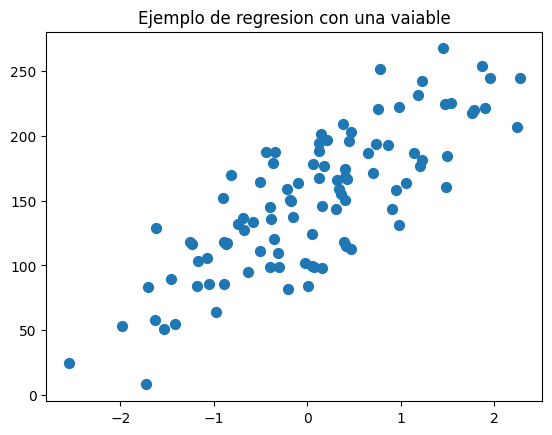

In [60]:
# synthetic dataset for simple regression
from sklearn.datasets import make_regression
plt.figure()
plt.title('Ejemplo de regresion con una vaiable')
X_R1, y_R1 = make_regression(n_samples = 100, n_features=1,
                            n_informative=1, bias = 150.0,
                            noise = 30, random_state=0)
plt.scatter(X_R1, y_R1, marker= 'o', s=50)
plt.show()

**Clasificación binaria simple**

Para ilustrar clasificación binaria, se usa un conjunto de datos con dos características informativas, dos clases posibles, usa la primera característica en el eje x y la segunda característica en el eje y. El color indica la clase. En este caso, las clases son aproximadamente separables de forma lineal, lo que permite que un clasificador lineal básico funcione bien.

Se añade algo de ruido en las etiquetas para hacer el problema ligeramente más realista y desafiante.

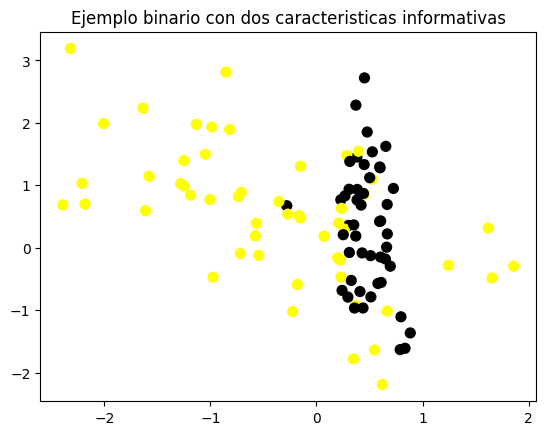

In [61]:
plt.figure()
plt.title('Ejemplo binario con dos caracteristicas informativas')
X_C2, y_C2 = make_classification(n_samples = 100, n_features=2,
                                n_redundant=0, n_informative=2,
                                n_clusters_per_class=1, flip_y = 0.1,
                                class_sep = 0.5, random_state=0)
plt.scatter(X_C2[:, 0], X_C2[:, 1], c=y_C2,
           marker= 'o', s=50, cmap=cmap_bold)
plt.show()

**Clasificación binaria no lineal**

También se estudia un problema de clasificación binaria más complejo, donde, las clases no son linealmente separables, los datos forman múltiples clústeres en el espacio de características, este tipo de dataset muestra situaciones donde, un modelo lineal ya no es suficiente y se requieren modelos más flexibles para capturar la estructura de los datos

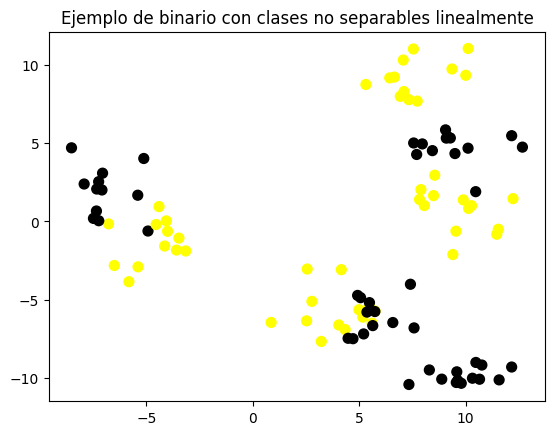

In [62]:
X_D2, y_D2 = make_blobs(n_samples = 100, n_features = 2, centers = 8,
                       cluster_std = 1.3, random_state = 4)
y_D2 = y_D2 % 2
plt.figure()
plt.title('Ejemplo de binario con clases no separables linealmente')
plt.scatter(X_D2[:,0], X_D2[:,1], c=y_D2,
           marker= 'o', s=50, cmap=cmap_bold)
plt.show()


**Regresión con datos del mundo real**

Finalmente, se presenta un problema de regresión real usando un dataset basado en datos de comunidades y crimen:

Cada observación representa una región geográfica, se utilizan muchas características (alta dimensión), el objetivo es predecir la tasa per cápita de crimen violento, este ejemplo muestra las diferencias clave entre:

Datasets sintéticos (simples, interpretables)

Datasets reales (alta dimensión, más complejos y menos intuitivos)

In [63]:
def load_crime_dataset():
    # Communities and Crime dataset for regression
    # https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized

    crime = pd.read_table('/content/CommViolPredUnnormalizedData.txt', sep=',', na_values='?')
    # remove features with poor coverage or lower relevance, and keep ViolentCrimesPerPop target column
    columns_to_keep = [5, 6] + list(range(11,26)) + list(range(32, 103)) + [145]
    crime = crime.iloc[:,columns_to_keep].dropna()

    X_crime = crime.iloc[:,range(0,88)]
    y_crime = crime['ViolentCrimesPerPop']
    print(crime)
    return (X_crime, y_crime)

In [64]:
(X_crime, y_crime) = load_crime_dataset()

      population  householdsize  agePct12t21  agePct12t29  agePct16t24  \
0          11980           3.10        12.47        21.44        10.93   
1          23123           2.82        11.01        21.30        10.48   
2          29344           2.43        11.36        25.88        11.01   
3          16656           2.40        12.55        25.20        12.19   
5         140494           2.45        18.09        32.89        20.04   
...          ...            ...          ...          ...          ...   
2210       56216           3.07        15.46        30.16        14.34   
2211       12251           2.68        17.36        31.23        16.97   
2212       32824           2.46        11.81        20.96         9.53   
2213       13547           2.89        17.16        30.01        14.73   
2214       28898           2.61        12.99        25.21        11.63   

      agePct65up  numbUrban  pctUrban  medIncome  pctWWage  ...  \
0          11.33      11980    100.00      7

##Modelo de k-vecinos más cercanos (KNN)



Este módulo retoma el modelos vistos en el primer apartado del Github: k-vecinos más cercanos (KNN), es un buen punto de partida en aprendizaje supervisado porque es intuitivo y es fácil de interpretar, puede usarse tanto para clasificación como para regresión.

En clasificación, el algoritmo de k-vecinos más cercanos funciona de forma muy directa, memoriza todo el conjunto de entrenamiento, para una nueva instancia encuentra los k puntos más cercanos y obtiene sus etiquetas, predice la clase por mayoría de votos. No aprende una función explícita, sino que consulta los datos de entrenamiento cada vez que predice.

In [65]:
from sklearn import neighbors
import numpy
import matplotlib.patches as mpatches

def plot_two_class_knn(X, y, n_neighbors, weights, X_test, y_test):
    X_mat = X
    y_mat = y

    # Create color maps
    cmap_light = ListedColormap(['#FFFFAA', '#AAFFAA', '#AAAAFF','#EFEFEF'])
    cmap_bold  = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])

    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X_mat, y_mat)

    # Plot the decision boundary by assigning a color in the color map
    # to each mesh point.

    mesh_step_size = .01  # step size in the mesh
    plot_symbol_size = 50

    x_min, x_max = X_mat[:, 0].min() - 1, X_mat[:, 0].max() + 1
    y_min, y_max = X_mat[:, 1].min() - 1, X_mat[:, 1].max() + 1
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, mesh_step_size),
                         numpy.arange(y_min, y_max, mesh_step_size))
    Z = clf.predict(numpy.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot training points
    plt.scatter(X_mat[:, 0], X_mat[:, 1], s=plot_symbol_size, c=y, cmap=cmap_bold, edgecolor = 'black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    title = "Neighbors = {}".format(n_neighbors)
    if (X_test is not None):
        train_score = clf.score(X_mat, y_mat)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    patch0 = mpatches.Patch(color='#FFFF00', label='class 0')
    patch1 = mpatches.Patch(color='#000000', label='class 1')
    plt.legend(handles=[patch0, patch1])

    plt.xlabel('Feature 0')
    plt.ylabel('Feature 1')
    plt.title(title)

    plt.show()


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_C2, y_C2,random_state=0)

**Regiones de decisión y complejidad del modelo**

Cuando se usa k = 1, cada punto de entrenamiento define su propia región, el límite de decisión es muy irregular, el modelo tiene alta varianza, se ajusta perfectamente a los datos de entrenamiento

Este es un ejemplo claro de sobreajuste: el modelo memoriza los datos pero ignora la tendencia global entre las clases.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


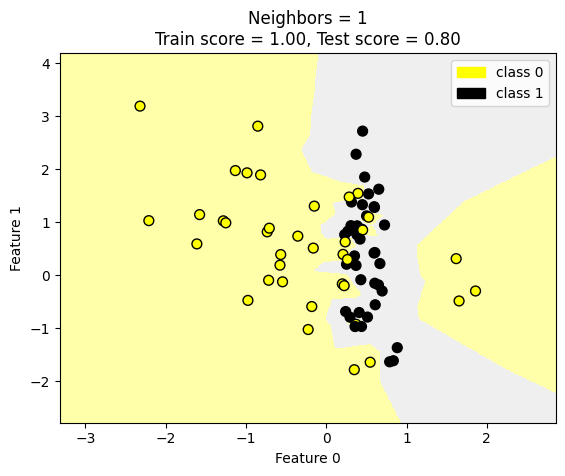

In [67]:
plot_two_class_knn(X_train, y_train, 1, 'uniform', X_test, y_test)

Al aumentar el valor de k (por ejemplo, k = 11), cada punto individual tiene menos influencia, los límites de decisión se vuelven más suaves, el modelo es menos complejo, disminuye la varianza y si k llega a ser tan grande como el número total de puntos, el modelo siempre predice la clase más frecuente y el modelo se vuelve demasiado simple

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


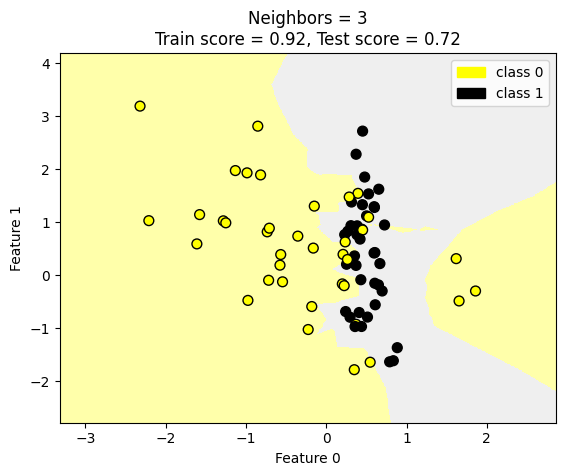

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


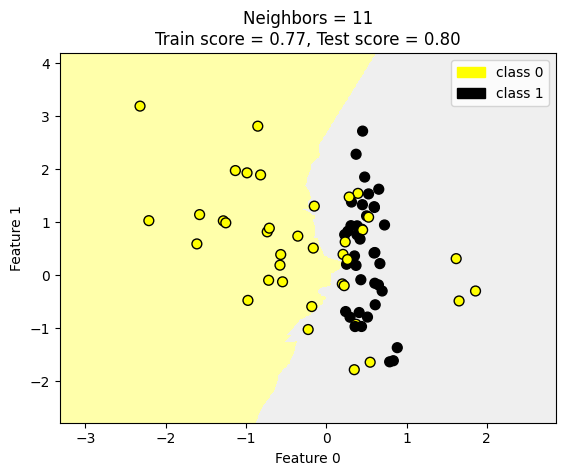

In [68]:
plot_two_class_knn(X_train, y_train, 3, 'uniform', X_test, y_test)
plot_two_class_knn(X_train, y_train, 11, 'uniform', X_test, y_test)

El comportamiento típico observado es:

si k es pequeño, el puntaje de entrenamiento muy alto y Puntaje de prueba bajo

k intermedio, Menor ajuste al entrenamiento y Mejor desempeño en prueba

k muy grande, Mal desempeño tanto en entrenamiento como en prueba

Esto ilustra claramente el compromiso entre complejidad del modelo y generalización.

**KNN para regresión**

El mismo enfoque se puede aplicar a regresión, con una diferencia clave, trabaja en tiempo discreto, por lo que no hay votos por clase, se promedian los valores objetivo de los k vecinos más cercanos y para un punto de consulta se buscan los k valores de x más cercanos, se promedian sus valores de y ese promedio es la predicción.

In [69]:
from sklearn.neighbors import KNeighborsRegressor

X_train, X_test, y_train, y_test = train_test_split(X_R1, y_R1, random_state = 0)

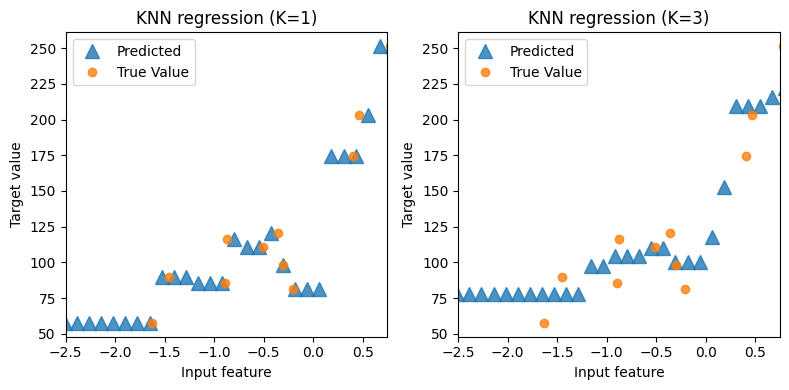

In [70]:
fig, subaxes = plt.subplots(1, 2, figsize=(8,4))
X_predict_input = np.linspace(-3, 3, 50).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X_R1[0::5], y_R1[0::5], random_state = 0)

for thisaxis, K in zip(subaxes, [1, 3]):
    knnreg = KNeighborsRegressor(n_neighbors = K).fit(X_train, y_train)
    y_predict_output = knnreg.predict(X_predict_input)
    thisaxis.set_xlim([-2.5, 0.75])
    thisaxis.plot(X_predict_input, y_predict_output, '^', markersize = 10,
                 label='Predicted', alpha=0.8)
    thisaxis.plot(X_train, y_train, 'o', label='True Value', alpha=0.8)
    thisaxis.set_xlabel('Input feature')
    thisaxis.set_ylabel('Target value')
    thisaxis.set_title('KNN regression (K={})'.format(K))
    thisaxis.legend()
plt.tight_layout()

Ejemplo: si tenemos un feature = -1.0, en k=1 lo pondrá en menos de 100, mientras que para k = 3, se pondra por encima de 100 el valor a predecir.

**KNN para clasificación**

El objetivo es discreto (clases), ejemplo: {0, 1}, {manzana, naranja}, {spam, no spam}, predice mirando las etiquetas de clase de los k vecinos y la clase por mayoría de votos

**KNN para regresión**

El objetivo es continuo, ejemplo: precio, temperatura, edad, tasa de crimen, predice mirando los valores numéricos de los k vecinos y el promedio (u otra agregación) de esos valores

**Evaluación en regresión: R²**

Para evaluar modelos de regresión se usa el coeficiente de determinación (R²), con R² = 1 → predicciones perfectas y R² = 0 → modelo que siempre predice el valor promedio, valores más altos indican mejor ajuste

Se observa el mismo patrón que en clasificación:

R² entrenamiento ↓ cuando k ↑

R² prueba ↑ hasta un punto óptimo

Luego ambos ↓ por subajuste

In [71]:
knnreg = KNeighborsRegressor(n_neighbors = 5).fit(X_train, y_train)

print(knnreg.predict(X_test))
print('R-squared test score: {:.3f}'
     .format(knnreg.score(X_test, y_test)))

[ 92.08 208.92  92.08 220.34 104.69]
R-squared test score: -0.135


**Visualización y evaluación del modelo KNN de regresión**

En esta parte se visualiza el comportamiento del modelo de regresión k-vecinos más cercanos y se evalúa su desempeño tanto en el conjunto de entrenamiento como en el de prueba.

Para cada valor de $k$ Se calcula el coeficiente de determinación $R^2$
 sobre los datos de entrenamiento y de prueba.

Se grafica la función de predicción del modelo sobre un rango continuo de valores de la variable de entrada. Se superponen los puntos de entrenamiento y prueba para comparar visualmente el ajuste del modelo con los datos reales.

La curva azul representa la predicción del modelo KNN para cada valor de entrada, mientras que los puntos circulares corresponden a los datos de entrenamiento, los triángulos corresponden a los datos de prueba


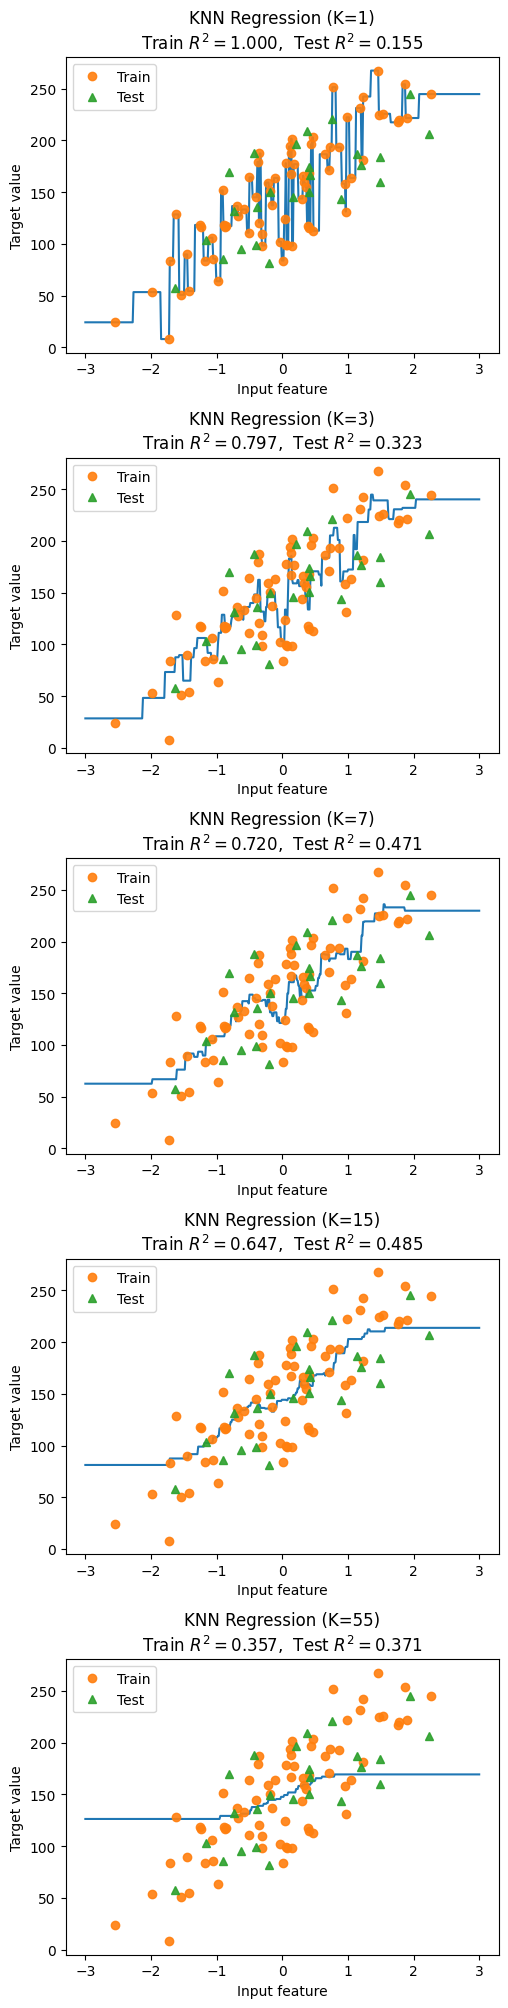

In [72]:
# plot k-NN regression on sample dataset for different values of K
fig, subaxes = plt.subplots(5, 1, figsize=(5,20))
X_predict_input = np.linspace(-3, 3, 500).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X_R1, y_R1,
                                                   random_state = 0)

for thisaxis, K in zip(subaxes, [1, 3, 7, 15, 55]):
    knnreg = KNeighborsRegressor(n_neighbors = K).fit(X_train, y_train)
    y_predict_output = knnreg.predict(X_predict_input)
    train_score = knnreg.score(X_train, y_train)
    test_score = knnreg.score(X_test, y_test)
    thisaxis.plot(X_predict_input, y_predict_output)
    thisaxis.plot(X_train, y_train, 'o', alpha=0.9, label='Train')
    thisaxis.plot(X_test, y_test, '^', alpha=0.9, label='Test')
    thisaxis.set_xlabel('Input feature')
    thisaxis.set_ylabel('Target value')
    thisaxis.set_title('KNN Regression (K={})\n\
Train $R^2 = {:.3f}$,  Test $R^2 = {:.3f}$'
                      .format(K, train_score, test_score))
    thisaxis.legend()
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


## Regresión lineal

La regresión lineal es uno de los modelos supervisados más simples y fundamentales, asume que la relación entre las variables de entrada y la variable objetivo puede aproximarse mediante una combinación lineal de las características.

El modelo aprende dos tipos de parámetros:

Coeficientes (w) que miden la contribución de cada característica

Intercepto (b) es el valor base de la predicción cuando las entradas son cero

Una vez entrenado, el modelo produce predicciones estables y fáciles de interpretar, La predicción 𝑦 se obtiene como una combinación lineal de las entradas

**Regresión lineal en un dataset sintético (1 característica)**

In [73]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X_R1, y_R1,
                                                   random_state = 0)
linreg = LinearRegression().fit(X_train, y_train)

print('linear model coeff (w): {}'
     .format(linreg.coef_))
print('linear model intercept (b): {:.3f}'
     .format(linreg.intercept_))
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))

linear model coeff (w): [45.71]
linear model intercept (b): 148.446
R-squared score (training): 0.679
R-squared score (test): 0.492


**Mínimos cuadrados ordinarios**

El método más común para entrenar modelos de regresión lineal es la regresión lineal por mínimos cuadrados, este método busca, minimizar el error cuadrático medio (MSE), es decir, el promedio de las diferencias al cuadrado entre los valores reales y los valores predichos

Intuitivamente, cada punto de entrenamiento genera un error, el modelo óptimo es el que minimiza la suma total de esos errores cuadrados, esta cantidad también se conoce como suma de residuos al cuadrado. Esto produce una única solución óptima para los parámetros 𝑤 y 𝑏. <br>

- Los puntos representan los datos reales.

- La línea roja es la solución de mínimos cuadrados.

- El modelo captura la tendencia global lineal, sin ajustarse al ruido local.

- A diferencia de KNN, la forma del modelo no cambia localmente.

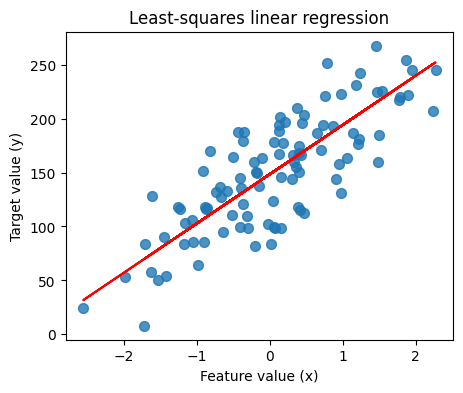

In [74]:
plt.figure(figsize=(5,4))
plt.scatter(X_R1, y_R1, marker= 'o', s=50, alpha=0.8)
plt.plot(X_R1, linreg.coef_ * X_R1 + linreg.intercept_, 'r-')
plt.title('Least-squares linear regression')
plt.xlabel('Feature value (x)')
plt.ylabel('Target value (y)')
plt.show()

**Evaluación del modelo**

Al igual que con KNN, el desempeño del modelo se evalúa usando:

El coeficiente de determinación 𝑅^2, esto permite comparar el ajuste en entrenamiento y la capacidad de generalización en prueba

In [75]:
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))

R-squared score (training): 0.679
R-squared score (test): 0.492


**Comparación: regresión lineal vs KNN**

Este módulo destaca una comparación importante entre dos enfoques de regresión:

**KNN**

- Hace pocas suposiciones sobre los datos

- Se ajusta muy bien al entrenamiento

- Puede ser inestable y sensible al ruido

**Regresión lineal**

- Hace una suposición fuerte: la relación es aproximadamente lineal

- Produce predicciones más estables

- Generaliza mejor cuando esa suposición es razonable

Podemos evaluar los modelos con el mayor $R^2$, ademas un modelo más simple puede generalizar mejor si sus supuestos coinciden con la estructura real de los datos.

## Regresion Lineal Ridge

La regresión Ridge es una extensión de la regresión lineal por mínimos cuadrados que incorpora regularización, con el objetivo de reducir el sobreajuste y mejorar la generalización del modelo.

Mientras que la regresión lineal ordinaria busca minimizar únicamente el error cuadrático, Ridge añade una penalización sobre el tamaño de los coeficientes.

Modelo lineal:

$$\hat{y}=𝑤^𝑇𝑥+𝑏$$

Función objetivo de Ridge:

$$∑^n_{i=1}(y_i - \hat{y_i})^2 + α ∑^p_{j=1}w^2_j  $$


El primer término mide el error de ajuste, el segundo término es la penalización L2 y 𝛼 controla la intensidad de la regularización. Valores grandes de $w_j$ aumentan la penalización, por lo que el modelo prefiere coeficientes pequeños.

In [76]:
#Ajustamos un modelo Ridge al dataset de crimen, usa 𝛼=20, lo que impone una regularización moderada

from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(X_crime, y_crime,
                                                   random_state = 0)

linridge = Ridge(alpha=20.0).fit(X_train, y_train)

In [77]:
print('Crime dataset')
print('ridge regression linear model intercept: {}'
     .format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))

Crime dataset
ridge regression linear model intercept: -3352.4230358461004
ridge regression linear model coeff:
[ 1.95e-03  2.19e+01  9.56e+00 -3.59e+01  6.36e+00 -1.97e+01 -2.81e-03
  1.66e+00 -6.61e-03 -6.95e+00  1.72e+01 -5.63e+00  8.84e+00  6.79e-01
 -7.34e+00  6.70e-03  9.79e-04  5.01e-03 -4.90e+00 -1.79e+01  9.18e+00
 -1.24e+00  1.22e+00  1.03e+01 -3.78e+00 -3.73e+00  4.75e+00  8.43e+00
  3.09e+01  1.19e+01 -2.05e+00 -3.82e+01  1.85e+01  1.53e+00 -2.20e+01
  2.46e+00  3.29e-01  4.02e+00 -1.13e+01 -4.70e-03  4.27e+01 -1.23e-03
  1.41e+00  9.35e-01 -3.00e+00  1.12e+00 -1.82e+01 -1.55e+01  2.42e+01
 -1.32e+01 -4.20e-01 -3.60e+01  1.30e+01 -2.81e+01  4.39e+01  3.87e+01
 -6.46e+01 -1.64e+01  2.90e+01  4.15e+00  5.34e+01  1.99e-02 -5.47e-01
  1.24e+01  1.04e+01 -1.57e+00  3.16e+00  8.78e+00 -2.95e+01 -2.33e-04
  3.14e-04 -4.14e-04 -1.80e-04 -5.74e-01 -5.18e-01 -4.21e-01  1.53e-01
  1.33e+00  3.85e+00  3.03e+00 -3.78e+01  1.38e-01  3.08e-01  1.57e+01
  3.31e-01  3.36e+00  1.61e-01 -2.68

Ridge no elimina variables, solo reduce su magnitud

Todos los coeficientes suelen ser distintos de cero

El R² de test es comparable al de mínimos cuadrados si no se escalan las variables

**Importancia de la normalización de características**

La penalización L2 depende directamente del tamaño de los coeficientes.
Si las características tienen escalas diferentes, la regularización no se aplica de forma justa.

Ejemplo: population en miles e income en decenas

El modelo penaliza más a unas variables que a otras solo por su escala.<br>
<br>

**Normalización Min-Max**

Transformación:
$$x'=\frac{x-x_{min}}{x_{max}-x_{min}}$$
Todas las variables quedan en el rango [0,1]

In [78]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(X_crime, y_crime, random_state = 0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linridge = Ridge(alpha=20.0).fit(X_train_scaled, y_train)


In [79]:
print('Crime dataset')
print('ridge regression linear model intercept: {}'
     .format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))

Crime dataset
ridge regression linear model intercept: 933.3906385044157
ridge regression linear model coeff:
[  88.69   16.49  -50.3   -82.91  -65.9    -2.28   87.74  150.95   18.88
  -31.06  -43.14 -189.44   -4.53  107.98  -76.53    2.86   34.95   90.14
   52.46  -62.11  115.02    2.67    6.94   -5.67 -101.55  -36.91   -8.71
   29.12  171.26   99.37   75.07  123.64   95.24 -330.61 -442.3  -284.5
 -258.37   17.66 -101.71  110.65  523.14   24.82    4.87  -30.47   -3.52
   50.58   10.85   18.28   44.11   58.34   67.09  -57.94  116.14   53.81
   49.02   -7.62   55.14  -52.09  123.39   77.13   45.5   184.91  -91.36
    1.08  234.09   10.39   94.72  167.92  -25.14   -1.18   14.6    36.77
   53.2   -78.86   -5.9    26.05  115.15   68.74   68.29   16.53  -97.91
  205.2    75.97   61.38  -79.83   67.27   95.67  -11.88]
R-squared score (training): 0.615
R-squared score (test): 0.599
Number of non-zero features: 88


Tras escalar, Ridge mejora notablemente su R² en test, supera tanto a Ridge sin escalar como a mínimos cuadrados. La regularización es mucho más efectiva cuando las características están normalizadas.

**Efecto del parámetro de regularización α en Ridge**

El parámetro 𝛼 controla el equilibrio entre el ajuste a los datos y la simplicidad del modelo

In [80]:
print('Ridge regression: effect of alpha regularization parameter\n')
for this_alpha in [0, 1, 10, 20, 50, 100, 1000]:
    linridge = Ridge(alpha = this_alpha).fit(X_train_scaled, y_train)
    r2_train = linridge.score(X_train_scaled, y_train)
    r2_test = linridge.score(X_test_scaled, y_test)
    num_coeff_bigger = np.sum(abs(linridge.coef_) > 1.0)
    print('Alpha = {:.2f}\nnum abs(coeff) > 1.0: {}, \
r-squared training: {:.2f}, r-squared test: {:.2f}\n'
         .format(this_alpha, num_coeff_bigger, r2_train, r2_test))

Ridge regression: effect of alpha regularization parameter

Alpha = 0.00
num abs(coeff) > 1.0: 88, r-squared training: 0.67, r-squared test: 0.50

Alpha = 1.00
num abs(coeff) > 1.0: 87, r-squared training: 0.66, r-squared test: 0.56

Alpha = 10.00
num abs(coeff) > 1.0: 87, r-squared training: 0.63, r-squared test: 0.59

Alpha = 20.00
num abs(coeff) > 1.0: 88, r-squared training: 0.61, r-squared test: 0.60

Alpha = 50.00
num abs(coeff) > 1.0: 86, r-squared training: 0.58, r-squared test: 0.58

Alpha = 100.00
num abs(coeff) > 1.0: 87, r-squared training: 0.55, r-squared test: 0.55

Alpha = 1000.00
num abs(coeff) > 1.0: 84, r-squared training: 0.31, r-squared test: 0.30



Se evalúa: R² en entrenamiento, R² en prueba, Número de coeficientes grandes

Interpretación general
- 𝛼=0 la regresión lineal ordinaria
- 𝛼 pequeño → riesgo de sobreajuste
- 𝛼 muy grande → subajuste

Existe un valor intermedio óptimo. En este dataset, el mejor rendimiento ocurre alrededor de α ≈ 20

##Regresión Lasso (L1)


Idea principal

La regresión Lasso también es un modelo lineal regularizado, pero usa una penalización diferente que puede eliminar variables automáticamente.

Función objetivo:

$$min_{w,b} \sum^n_{i=1}(y_i-\hat{y_i})^2+α ∑^p_{j=1}|w_j|$$

Diferencia clave:

Ridge → penaliza $w_j^2$

Lasso → penaliza $|w_j|$ <br><br>

- Muchos coeficientes se hacen exactamente cero
- El modelo se vuelve disperso
- Actúa como selección automática de características

In [81]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X_crime, y_crime,
                                                   random_state = 0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linlasso = Lasso(alpha=2.0, max_iter = 10000).fit(X_train_scaled, y_train)

In [82]:
print('Crime dataset')
print('lasso regression linear model intercept: {}'
     .format(linlasso.intercept_))
print('lasso regression linear model coeff:\n{}'
     .format(linlasso.coef_))
print('Non-zero features: {}'
     .format(np.sum(linlasso.coef_ != 0)))
print('R-squared score (training): {:.3f}'
     .format(linlasso.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}\n'
     .format(linlasso.score(X_test_scaled, y_test)))
print('Features with non-zero weight (sorted by absolute magnitude):')

Crime dataset
lasso regression linear model intercept: 1186.612061998579
lasso regression linear model coeff:
[    0.       0.      -0.    -168.18    -0.      -0.       0.     119.69
     0.      -0.       0.    -169.68    -0.       0.      -0.       0.
     0.       0.      -0.      -0.       0.      -0.       0.       0.
   -57.53    -0.      -0.       0.     259.33    -0.       0.       0.
     0.      -0.   -1188.74    -0.      -0.      -0.    -231.42     0.
  1488.37     0.      -0.      -0.      -0.       0.       0.       0.
     0.       0.      -0.       0.      20.14     0.       0.       0.
     0.       0.     339.04     0.       0.     459.54    -0.       0.
   122.69    -0.      91.41     0.      -0.       0.       0.      73.14
     0.      -0.       0.       0.      86.36     0.       0.       0.
  -104.57   264.93     0.      23.45   -49.39     0.       5.2      0.  ]
Non-zero features: 20
R-squared score (training): 0.631
R-squared score (test): 0.624

Features with n

Solo un subconjunto de variables queda activo, el modelo es más interpretable, util cuando pocas variables tienen impacto fuerte

Advertencia:
En problemas complejos (como crimen), los coeficientes reflejan correlaciones, no causalidad.

In [83]:
for e in sorted (list(zip(list(X_crime), linlasso.coef_)),
                key = lambda e: -abs(e[1])):
    if e[1] != 0:
        print('\t{}, {:.3f}'.format(e[0], e[1]))

	PctKidsBornNeverMar, 1488.365
	PctKids2Par, -1188.740
	HousVacant, 459.538
	PctPersDenseHous, 339.045
	NumInShelters, 264.932
	MalePctDivorce, 259.329
	PctWorkMom, -231.423
	pctWInvInc, -169.676
	agePct12t29, -168.183
	PctVacantBoarded, 122.692
	pctUrban, 119.694
	MedOwnCostPctIncNoMtg, -104.571
	MedYrHousBuilt, 91.412
	RentQrange, 86.356
	OwnOccHiQuart, 73.144
	PctEmplManu, -57.530
	PctBornSameState, -49.394
	PctForeignBorn, 23.449
	PctLargHouseFam, 20.144
	PctSameCity85, 5.198


**Efecto de α en Lasso**



In [84]:
print('Lasso regression: effect of alpha regularization\n\
parameter on number of features kept in final model\n')

for alpha in [0.5, 1, 2, 3, 5, 10, 20, 50]:
    linlasso = Lasso(alpha, max_iter = 10000).fit(X_train_scaled, y_train)
    r2_train = linlasso.score(X_train_scaled, y_train)
    r2_test = linlasso.score(X_test_scaled, y_test)

    print('Alpha = {:.2f}\nFeatures kept: {}, r-squared training: {:.2f}, \
r-squared test: {:.2f}\n'
         .format(alpha, np.sum(linlasso.coef_ != 0), r2_train, r2_test))

Lasso regression: effect of alpha regularization
parameter on number of features kept in final model

Alpha = 0.50
Features kept: 35, r-squared training: 0.65, r-squared test: 0.58

Alpha = 1.00
Features kept: 25, r-squared training: 0.64, r-squared test: 0.60

Alpha = 2.00
Features kept: 20, r-squared training: 0.63, r-squared test: 0.62

Alpha = 3.00
Features kept: 17, r-squared training: 0.62, r-squared test: 0.63

Alpha = 5.00
Features kept: 12, r-squared training: 0.60, r-squared test: 0.61

Alpha = 10.00
Features kept: 6, r-squared training: 0.57, r-squared test: 0.58

Alpha = 20.00
Features kept: 2, r-squared training: 0.51, r-squared test: 0.50

Alpha = 50.00
Features kept: 1, r-squared training: 0.31, r-squared test: 0.30



**Comportamiento general**

α pequeño → muchas variables activas

α grande → muy pocas variables

α demasiado grande → subajuste

Existe un compromiso entre la precisión predictiva y la simplicidad del modelo

## Regresión polinomial (Polynomial Regression)


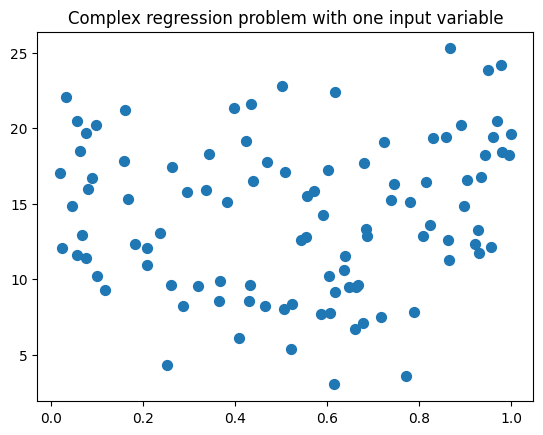

In [85]:
# synthetic dataset for more complex regression
from sklearn.datasets import make_friedman1
plt.figure()
plt.title('Complex regression problem with one input variable')
X_F1, y_F1 = make_friedman1(n_samples = 100,
                           n_features = 7, random_state=0)

plt.scatter(X_F1[:, 2], y_F1, marker= 'o', s=50)
plt.show()

La regresión polinomial no es un modelo no lineal, sino un modelo lineal en un espacio de características transformado.

Ejemplo teórico

Variables originales: $(x_0,x_1)$

Variables transformadas: $(1,x_0,x_1,x_0^2,x_0x_1,x_1^2)$

El modelo sigue siendo: $\hat{y}=w^T𝜙(x)$

In [86]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_F1_poly = poly.fit_transform(X_F1)

X_train, X_test, y_train, y_test = train_test_split(X_F1_poly, y_F1,
                                                   random_state = 0)
linreg = LinearRegression().fit(X_train, y_train)

In [87]:
print('(poly deg 2) linear model coeff (w):\n{}'
     .format(linreg.coef_))
print('(poly deg 2) linear model intercept (b): {:.3f}'
     .format(linreg.intercept_))
print('(poly deg 2) R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('(poly deg 2) R-squared score (test): {:.3f}\n'
     .format(linreg.score(X_test, y_test)))

(poly deg 2) linear model coeff (w):
[ 3.41e-12  1.66e+01  2.67e+01 -2.21e+01  1.24e+01  6.93e+00  1.05e+00
  3.71e+00 -1.34e+01 -5.73e+00  1.62e+00  3.66e+00  5.05e+00 -1.46e+00
  1.95e+00 -1.51e+01  4.87e+00 -2.97e+00 -7.78e+00  5.15e+00 -4.65e+00
  1.84e+01 -2.22e+00  2.17e+00 -1.28e+00  1.88e+00  1.53e-01  5.62e-01
 -8.92e-01 -2.18e+00  1.38e+00 -4.90e+00 -2.24e+00  1.38e+00 -5.52e-01
 -1.09e+00]
(poly deg 2) linear model intercept (b): -3.206
(poly deg 2) R-squared score (training): 0.969
(poly deg 2) R-squared score (test): 0.805



**Resultados observados**

Regresión lineal simple

- Bajo poder expresivo

Polinomial sin regularización

- R² entrenamiento ≈ 1

- R² prueba bajo → sobreajuste

Polinomial + Ridge

- Entrenamiento y prueba similares

- Mejor generalización

La expansión de características aumenta la complejidad y debe combinarse con regularización.

In [88]:
print('\nAddition of many polynomial features often leads to\n\
overfitting, so we often use polynomial features in combination\n\
with regression that has a regularization penalty, like ridge\n\
regression.\n')

X_train, X_test, y_train, y_test = train_test_split(X_F1_poly, y_F1,
                                                   random_state = 0)
linreg = Ridge().fit(X_train, y_train)

print('(poly deg 2 + ridge) linear model coeff (w):\n{}'
     .format(linreg.coef_))
print('(poly deg 2 + ridge) linear model intercept (b): {:.3f}'
     .format(linreg.intercept_))
print('(poly deg 2 + ridge) R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('(poly deg 2 + ridge) R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))


Addition of many polynomial features often leads to
overfitting, so we often use polynomial features in combination
with regression that has a regularization penalty, like ridge
regression.

(poly deg 2 + ridge) linear model coeff (w):
[ 0.    2.23  4.73 -3.15  3.86  1.61 -0.77 -0.15 -1.75  1.6   1.37  2.52
  2.72  0.49 -1.94 -1.63  1.51  0.89  0.26  2.05 -1.93  3.62 -0.72  0.63
 -3.16  1.29  3.55  1.73  0.94 -0.51  1.7  -1.98  1.81 -0.22  2.88 -0.89]
(poly deg 2 + ridge) linear model intercept (b): 5.418
(poly deg 2 + ridge) R-squared score (training): 0.826
(poly deg 2 + ridge) R-squared score (test): 0.825


Curvas de coeficientes (Coefficient paths)

Las curvas de coeficientes muestran cómo cambian los pesos del modelo al variar 𝛼.

Eje x:
log
⁡
(
𝛼
)

Eje y: valor del coeficiente

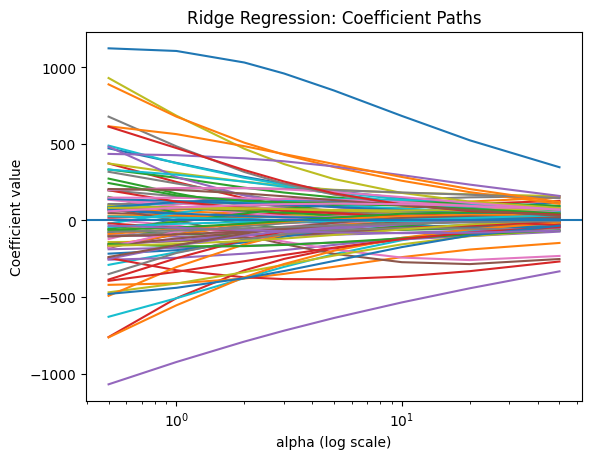

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Valores de alpha en escala logarítmica
alphas = [0.5, 1, 2, 3, 5, 10, 20, 50]

coefs = []

# Re-initialize X_train_scaled, X_test_scaled, y_train, y_test from X_crime and y_crime
scaler = MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(X_crime, y_crime, random_state = 0)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_scaled, y_train)
    coefs.append(ridge.coef_)

coefs = np.array(coefs)

plt.figure()
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('alpha (log scale)')
plt.ylabel('Coefficient value')
plt.title('Ridge Regression: Coefficient Paths')
plt.axhline(0)
plt.show()

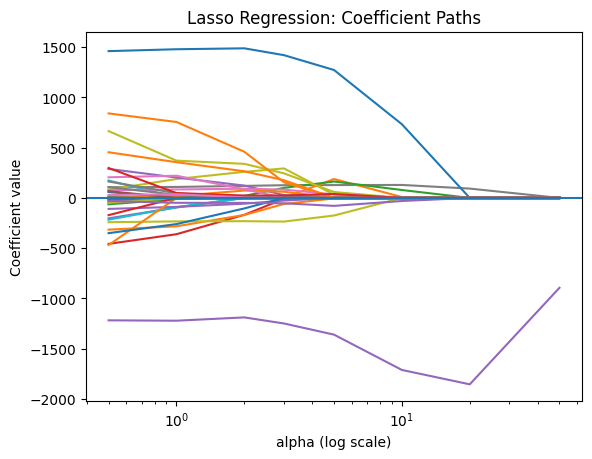

In [90]:
#import numpy as np
#import matplotlib.pyplot as plt
#from sklearn.linear_model import Lasso

alphas = [0.5, 1, 2, 3, 5, 10, 20, 50]

coefs = []

for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    coefs.append(lasso.coef_)

coefs = np.array(coefs)

plt.figure()
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('alpha (log scale)')
plt.ylabel('Coefficient value')
plt.title('Lasso Regression: Coefficient Paths')
plt.axhline(0)
plt.show()


**Interpretación conceptual**

Ridge: todos los coeficientes se contraen suavemente hacia 0

Lasso: muchos coeficientes llegan exactamente a 0

Estas curvas describen la ruta completa de soluciones del modelo.

Son una herramienta clave para entender: Regularización, Complejidad del modelo, Selección de variables

##Regresión logística: clasificación binaria


La regresión logística es un modelo de aprendizaje supervisado utilizado para clasificación, principalmente binaria. Aunque su nombre incluye “regresión”, su objetivo no es predecir valores continuos, sino asignar observaciones a una clase.

En este módulo, la regresión logística se usa para resolver problemas donde la variable objetivo toma valores:

$$y \in \{0.1\}$$


Ejemplos comunes: ¿Es una manzana o no? ¿El tumor es maligno o benigno?

**Modelo matemático y función sigmoide**

La regresión logística parte de una combinación lineal de las variables de entrada:

$$z=w^Tx+b$$

A diferencia de la regresión lineal, este valor no se usa directamente.
Se aplica la función logística (sigmoide):
$$\sigma(z)=\frac{1}{1+e^{-z}}$$

Esta función convierte cualquier número real en un valor entre 0 y 1, permite interpretar la salida como una probabilidad

**Interpretación probabilística**

La salida del modelo:
$$\hat{y}=\sigma(w^Tx+b)$$

se interpreta como:

$$P[y=1|x]$$

Es decir, la probabilidad de que una observación pertenezca a la clase positiva dado su vector de características.

La regla de decisión típica es:

Si $\hat{y} ≥0.5$ → clase positiva

Si $\hat{y} < 0.5$ → clase negativa

**Clasificación binaria en el dataset de frutas**

En el dataset de frutas, el problema original es multiclase.
Para aplicar regresión logística, se transforma en un problema binario:

Clase positiva: manzana

Clase negativa: todas las demás frutas

Solo se utilizan dos características: height y width

Esto permite visualizar fácilmente el límite de decisión.

In [97]:
#@title Grafico

def plot_class_regions_for_classifier_subplot(clf, X, y, X_test, y_test, title, subplot, target_names = None, plot_decision_regions = True):

    numClasses = numpy.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = numpy.meshgrid(numpy.arange(x_min-k, x_max+k, h), numpy.arange(y_min-k, y_max+k, h))

    P = clf.predict(numpy.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)

    if plot_decision_regions:
        subplot.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    subplot.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    subplot.set_xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    subplot.set_ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        subplot.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    subplot.set_title(title)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        subplot.legend(loc=0, handles=legend_handles)


In [101]:
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Load the fruit data
fruits = pd.read_table('/content/fruit_data_with_colors.txt')

# Prepare the X and y for the binary classification problem (using only height and width)
X_fruits_2d = fruits[['height', 'width']]
y_fruits_2d = fruits['fruit_label']

y_fruits_apple = y_fruits_2d == 1   # make into a binary problem: apples vs everything else
X_train, X_test, y_train, y_test = (train_test_split(X_fruits_2d.values,y_fruits_apple.values,random_state = 0))

clf = LogisticRegression(C=100).fit(X_train, y_train)

**Límite de decisión en regresión logística**

Con dos características, la regresión logística aprende un límite de decisión lineal. Este límite corresponde a los puntos donde la probabilidad predicha es 0.5.

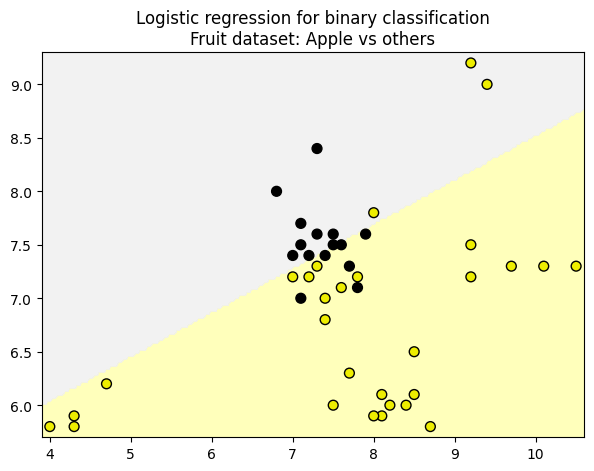

In [102]:
fig, subaxes = plt.subplots(1, 1, figsize=(7, 5))
plot_class_regions_for_classifier_subplot(clf, X_train, y_train, None,
                                         None, 'Logistic regression \
for binary classification\nFruit dataset: Apple vs others',
                                         subaxes)

Cada región corresponde a una clase. La frontera entre regiones es una línea recta. El modelo separa manzanas del resto basándose en altura y ancho

**Predicción de nuevas observaciones y Evaluación del modelo: accuracy**

Una vez entrenado, el modelo puede predecir si una fruta nueva es una manzana o no y la precisión (accuracy) mide la proporción de observaciones correctamente clasificadas.

El modelo para la predicción calcula la probabilidad, aplica el umbral de decisión y devuelve la clase más probable y para la evaluación muestra precisión alta en entrenamiento y prueba indica buena generalización, piferencias grandes entre ambos pueden indicar sobreajuste o subajuste

In [103]:
h = 6
w = 8
print('A fruit with height {} and width {} is predicted to be: {}'
     .format(h,w, ['not an apple', 'an apple'][int(clf.predict([[h,w]])[0])]))

h = 10
w = 7
print('A fruit with height {} and width {} is predicted to be: {}'
     .format(h,w, ['not an apple', 'an apple'][int(clf.predict([[h,w]])[0])]))
subaxes.set_xlabel('height')
subaxes.set_ylabel('width')

print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

A fruit with height 6 and width 8 is predicted to be: an apple
A fruit with height 10 and width 7 is predicted to be: not an apple
Accuracy of Logistic regression classifier on training set: 0.80
Accuracy of Logistic regression classifier on test set: 0.73


**Regresión logística en un dataset sintético**

Para entender mejor el comportamiento del modelo, se aplica regresión logística a un conjunto de datos artificial.

El límite de decisión es lineal. El modelo separa las clases de forma global. Es comparable a un clasificador lineal como SVM

Accuracy of Logistic regression classifier on training set: 0.81
Accuracy of Logistic regression classifier on test set: 0.84


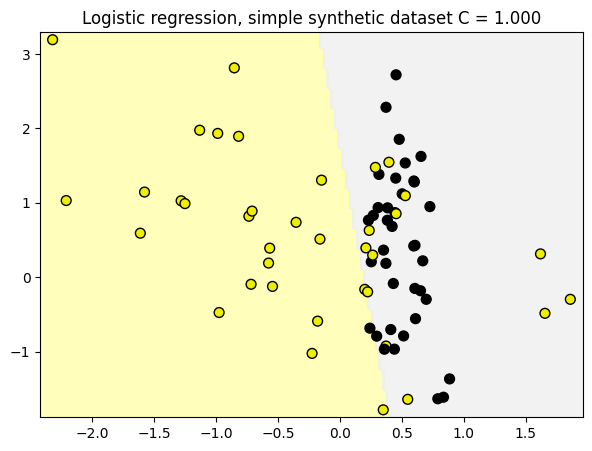

In [105]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X_C2, y_C2,
                                                   random_state = 0)

fig, subaxes = plt.subplots(1, 1, figsize=(7, 5))
clf = LogisticRegression().fit(X_train, y_train)
title = 'Logistic regression, simple synthetic dataset C = {:.3f}'.format(1.0)
plot_class_regions_for_classifier_subplot(clf, X_train, y_train,
                                         None, None, title, subaxes)

print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))


**Regularización en regresión logística: parámetro C**

La regresión logística incluye regularización L2 por defecto, el parámetro C controla su intensidad:

C pequeño → regularización fuerte

C grande → regularización débil

Relación conceptual:

$$Regularización ∝ \frac{1}{C}$$

**Efecto del parámetro C en el dataset de frutas**

Se entrena el modelo con distintos valores de C para observar cómo cambia el límite de decisión.

- C pequeño: frontera más simple y estable

- C grande: frontera más ajustada a los datos

- Valores grandes de C pueden llevar a sobreajuste

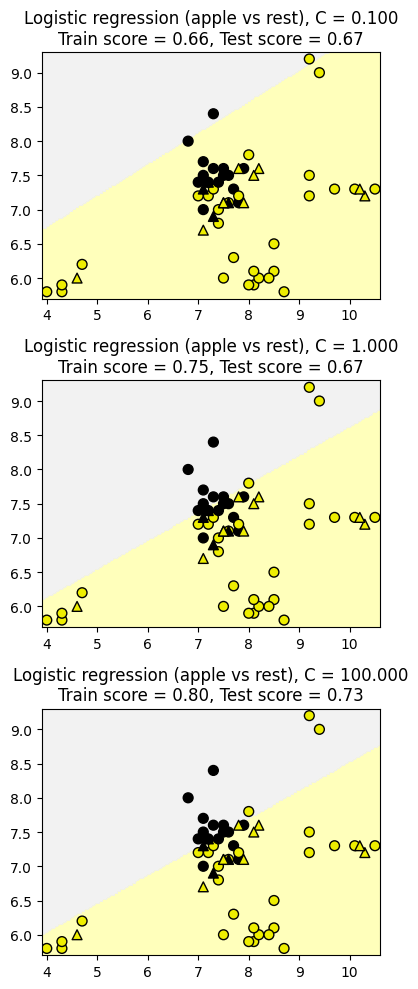

In [106]:
X_train, X_test, y_train, y_test = (
train_test_split(X_fruits_2d.values,
                y_fruits_apple.values,
                random_state=0))

fig, subaxes = plt.subplots(3, 1, figsize=(4, 10))

for this_C, subplot in zip([0.1, 1, 100], subaxes):
    clf = LogisticRegression(C=this_C).fit(X_train, y_train)
    title ='Logistic regression (apple vs rest), C = {:.3f}'.format(this_C)

    plot_class_regions_for_classifier_subplot(clf, X_train, y_train,
                                             X_test, y_test, title,
                                             subplot)
plt.tight_layout()

**Aplicación a un dataset real: cáncer de mama**

Finalmente, se aplica regresión logística a un dataset real con múltiples características.

In [107]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

clf = LogisticRegression().fit(X_train, y_train)
print('Breast cancer dataset')
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Breast cancer dataset
Accuracy of Logistic regression classifier on training set: 0.96
Accuracy of Logistic regression classifier on test set: 0.95


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Resultados**

- Alta precisión en entrenamiento y prueba

- El modelo generaliza bien

- La regresión logística es adecuada para problemas reales de clasificación binaria



---





---



##No sirve

In [91]:






# Breast cancer dataset for classification
cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)


# Communities and Crime dataset
(X_crime, y_crime) = load_crime_dataset()

      population  householdsize  agePct12t21  agePct12t29  agePct16t24  \
0          11980           3.10        12.47        21.44        10.93   
1          23123           2.82        11.01        21.30        10.48   
2          29344           2.43        11.36        25.88        11.01   
3          16656           2.40        12.55        25.20        12.19   
5         140494           2.45        18.09        32.89        20.04   
...          ...            ...          ...          ...          ...   
2210       56216           3.07        15.46        30.16        14.34   
2211       12251           2.68        17.36        31.23        16.97   
2212       32824           2.46        11.81        20.96         9.53   
2213       13547           2.89        17.16        30.01        14.73   
2214       28898           2.61        12.99        25.21        11.63   

      agePct65up  numbUrban  pctUrban  medIncome  pctWWage  ...  \
0          11.33      11980    100.00      7